# MCS 275 Spring 2023 Worksheet 9 Solutions

* Course instructor: David Dumas
* Contributors to this document: Johnny Joyce, Kylash Viswanathan

## Topics

We've covered a lot of small topics lately; this worksheet includes:
* `set` and `defaultdict`
* CSV and JSON
* Bitmap images using Pillow

## Resources

These things might be helpful while working on the problems.  Remember that for worksheets,  we don't strictly limit what resources you can consult, so these are only suggestions.

* [Course sample code repo](https://github.com/daviddumas/mcs275spring2023/blob/main/samplecode/)
* [Lecture 19 - set and defaultdict](http://dumas.io/teaching/2023/spring/mcs275/slides/lecture19.html)
* [Lecture 20 - CSV and JSON](http://dumas.io/teaching/2023/spring/mcs275/slides/lecture20.html)
* [Lecture 21 - Pillow](http://dumas.io/teaching/2023/spring/mcs275/slides/lecture21.html)
* [Downey's book](https://greenteapress.com/thinkpython2/html/)

## Make sure to get some practice on all the topics

If one of these problems ends up taking a lot of time, it might make sense to skip to another one or move on to another aspect of the problem so that you spend some time on each topic (set/defaultdict, CSV/JSON, Pillow) during lab.

## 1. Save and load trees as JSON files

Recall that we have two classes for building trees:
* `Node`, for generic binary trees
* `BST`, a subclass for binary search trees

Consider the following binary tree, made of `Node` objects:
```
          <True>
          /    \
   <"Alice">  <False>
    /     \
 <5.8>   <5.5>
```
If we wanted to save the tree to a file, JSON would be a natural choice as it allows nesting of data structures.  You can't write an arbitrary object (like `Node` or `BST`) to a JSOn file, but the tree above might be saved to a JSON file by creating a nested dictionary such as
```python
{
    "class": "Node",
    "tree": {
        "key": True,
        "left": {
            "key": "Alice",
            "left": {
                "key": 5.8,
                "left": None,
                "right": None
            },
            "right": {
                "key": 5.5,
                "left": None,
                "right": None
            }
        },
        "right": {
            "key": False,
            "left": None,
            "right": None
        }
    }
}
```
and then writing *that* to a file.

That would result in a JSON file with two top-level keys: `"class"` indicates what kind of tree it is (`BST` or `Node`), and `"tree"` maps to a hierarchy of objects that represent the nodes of the tree.

The same general approach could be applied to binary search trees, too.  This BST:
```
          <6> 

    <5>         <14>

 <4>         <10>  <16>
```
Could be saved to a JSON file as the dictionary
```python
{
    "class": "BST",
    "tree": {
        "key": 6,
        "left": {
            "key": 5,
            "left": {
                "key": 4,
                "left": None,
                "right": None
            },
            "right": None
        },
        "right": {
            "key": 14,
            "left": {
                "key": 10,
                "left": None,
                "right": None
            },
            "right": {
                "key": 16,
                "left": None,
                "right": None
            }
        }
    }
}
```

Add a method `save(fp)` to class `Node` in `trees.py` that will save a tree as JSON, writing it to an open file object `fp`.

Then, add a function to the module `trees.py` called `load(fp)` that takes an open file object, reads a JSON object from it, and then builds and returns the corresponding tree.  The return type should be either `Node` or `BST` depending on what is found in the JSON file.

Suggestions / hints:
* At first, ignore the `BST` case and build a version that works for `Node` objects.  In fact, ignore the `BST` case entirely unless you have time to add that at the end.
* A key step is converting a tree to a collection of nested dictionaries.  I suggest making a separate method of `Node` called `as_dict_tree()` that handles this naturally recursive operation.  Then you can handle the top-level object creation (with `"class"` and `"tree"` keys) in the method `save` itself.
* A dictionary like `{"Node": Node, "BST": BST}` can be used to map names of classes to actual classes.  That allows you to build a `Node` or `BST` object depending on a string, e.g.

In [ ]:
node_classes = {"Node": Node, "BST": BST}

k = "Node"
A = node_classes[k](key=5)
# Now A is a Node object

k = "BST"
B = node_classes[k](key=11)
# Now B is a BST object

When you're done, the following code should build a BST, save it to a file, and load it back again.

In [ ]:
from trees import load, BST
from treevis import treeprint

T = BST()
T.insert(8)
T.insert(12)
T.insert(2)
T.insert(3)

with open("tree.json","w",encoding="UTF-8") as fp:
    T.save(fp)
    
with open("tree.json","r",encoding="UTF-8") as fp:
    W = load(fp)
    
print("Tree that was saved:")
treevis.treeprint(T)

print("Tree that was loaded:")
treevis.treeprint(W)

## Solution

Inside the class `Node`: (Note that this will also define the function for the class `BST` too)

In [ ]:
    def as_dict_tree(self):
        '''Returns representation of tree as a dictionary object so it can be saved'''
        
        # Initialize left and right keys as None so they can be overwritten if needed
        D = {"key": self.key, "left": None, "right": None}

        if self.left != None:
            D["left"] = self.left.as_dict_tree()

        if self.right != None:
            D["right"] = self.right.as_dict_tree()

        return D     

Also inside the class `Node` (be sure to `import json`):

In [ ]:
    def save(self, fn):
        '''Saves dictionary representation of tree as JSON file as `fn`.'''
        tree = self.as_dict_tree()
        json.dump({"class": self.__class__.__name__, "tree": tree}, fn)

In another file, define the `load` function (along with a recursive helper function called `dict_tree_to_nodes` to turn dictionaries into `Node`s or `BST`s)

In [ ]:
def dict_tree_to_nodes(D, node_type):
    '''Converts a dict object into a Node or BST.
    Argument `node_type' can be either `Node` or `BST` 
    (acting as a reference to the class itself, not a string).'''

    if D["left"] != None: # Recursive call on left side if needed
        left_node = dict_tree_to_nodes(D["left"], node_type)
    else:
        left_node = None
    
    if D["right"] != None: # Recursive call on right side if needed
        right_node = dict_tree_to_nodes(D["right"], node_type)
    else:
        right_node = None

    # Call the `node_type` class to initialize a node with left and right children
    return node_type(D["key"], left = left_node, right = right_node)


def load(fp):
    '''Loads a tree from a JSON file `fp`'''
    T = json.load(fp)
    if T["class"] == "Node":
        node_type = trees.Node
    else:
        node_type = trees.BST
    return dict_tree_to_nodes(T["tree"], node_type)

## 2. Pixel art color palette generator

*I recommend working on this problem in a Python notebook.*

Imagine you're a developer working on a project where many pixel art images will be incorporated into an application (e.g. a game, a GUI program, etc.).  A few of these images have already been drawn by various artists, and those artists were free to choose any colors they liked when doing so.  Here are links to those images:

* [ws9-pixelart1-med.png](images/ws9-pixelart1-med.png)

![](images/ws9-pixelart1-med.png)

* [ws9-pixelart2-med.png](images/ws9-pixelart2-med.png)

![](images/ws9-pixelart2-med.png)

* [ws9-pixelart3-med.png](images/ws9-pixelart3-med.png)

![](images/ws9-pixelart3-med.png)

But now there is a plan to standardize on a palette of a few colors, and to draw all remaining images using only that color palette.

Your task is to analyze the existing images and generate a list of the distinct colors that are used in them.  Ideally, the list should be ordered from most-frequently used colors (in terms of number of pixels) to least-frequently used.  However, if sorting by frequency proves to be too complicated, it's acceptable to simply produce a list of distinct colors in arbitrary order.

Make a program that does this, and which outputs the list in two ways:
1. As a CSV file `palette.csv` that has three columns, named `red`, `green`, and `blue`, and whose rows contain the distinct colors appearing in the sample images.  Its contents might look like this, for example:
```text
red,green,blue
18,210,194
241,231,108
...
```
2. An image file `palette.png` that is created by the program in which 32 of the colors are shown in a horizontal strip, with each one represented by a 16x64 (width x height) pixel rectangle filled with that color.  (Thus the image has dimensions 512x64.)  Here's a sample of what it might look like, but this sample doesn't show the colors listed above nor colors that necessarily appear in the sample images.
![](images/ws9-sample-palette.png)

### Follow-up question

Do these images actually have any colors in common, or is this simply a matter of concatenating the color lists from the three images?

### Note

This problem provides a natural opportunity to use several things:
* Either
    * `defaultdict` to track how many pixels have each color, OR
    * `set` to track the set of distinct colors (without tracking how often they are used)
* `csv` module to handle writing the palette to CSV file
* Pillow (`PIL` module), to manage loading of the sample images and saving of `palette.png`

## Solution

In [1]:
from PIL import Image

art = [ Image.open("ws9-pixelart{}-med.png".format(i)) for i in range(1,4) ]

In [2]:
def image_colors(img):
    """Return a list of the pixel colors in PIL image object `img` (one per pixel)"""
    xs = img.size[0]
    ys = img.size[1]
    L = []
    # Iterate over all pixel coords (x,y) and get corresponding color
    for x in range(xs):
        for y in range(ys):
            L.append(img.getpixel( (x,y) )) # Note that (x,y) must be given as a single argument 
                                            # (I.e. inside a list or tuple)
    return L

In [10]:
def distinct_colors(img):
    """Set of distinct colors in given PIL image `img`"""
    return set(image_colors(img))

for i in range(3):
    for j in range(3):
        if i < j:
            print("Image {} and {} share {} color(s)".format(i+1, j+1,
                len(distinct_colors(art[i]) & distinct_colors(art[j]))))

Image 1 and 2 share 1 color(s)
Image 1 and 3 share 1 color(s)
Image 2 and 3 share 2 color(s)


In [5]:
import collections

color_frequencies = collections.defaultdict(int)
for img in art:
    for c in image_colors(img):
        color_frequencies[c] += 1

def color_popularity(c):
    """Sorting key for sorting by number of occurrences of a single color"""
    return color_frequencies[c]

popular_colors = sorted(color_frequencies, key=color_popularity, reverse=True)

In [6]:
import csv
with open("palette.csv","w",newline="",encoding="UTF-8") as fp:
    writer = csv.DictWriter(fp,fieldnames=["red","green","blue"])
    writer.writeheader()
    for color in popular_colors:
        writer.writerow({ "red":color[0], "green":color[1], "blue":color[2] })

In [27]:
# There are other ways to draw a box with PIL but the simplest is to
# iterate over all pixels and compute the color for each one
palette_img = Image.new("RGB",(512,64))
for x in range(512):
    for y in range(64):
        palette_img.putpixel((x,y), popular_colors[x // 16] )

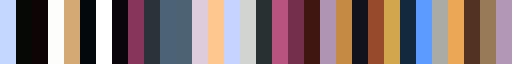

In [28]:
palette_img

## 3. Accidentally quadratic

Here is a function that takes two strings and returns the set of characters that appear in both strings.

In [118]:
def common_chars(s1,s2):
    """Return a set of all characters that are present in both
    strings `s1` and `s2`."""
    common = set()
    for c1 in s1:
        if c1 in s2:
            common.add(c1)
    return common

It works.  Here's a simple example:

In [49]:
common_chars("mathematics","computer science")

{'c', 'e', 'i', 'm', 's', 't'}

However, this function is actually **needlessly slow**.  Here's an example that generates two strings that each have `50,000` characters, runs `common_chars` on them, and prints the total time.

In [50]:
import random
import time

s1 = ''.join([ random.choice(["edfghijklmnopqrstuvwxyzzzzzzzzzzzzzzzz"]) for _ in range(50000) ])
s2 = ''.join([ random.choice(["abcedfghijklmnopqrstuvw"]) for _ in range(50000) ]) + 'z'

t_start = time.time()
both = common_chars(s1,s2)
t_end = time.time()

print("Common characters:")
print(both)
print("\nRunning time: {:.2f} seconds".format(t_end-t_start))

Common characters:
{'w', 'n', 't', 'f', 'r', 'm', 'z', 'q', 'p', 'e', 'i', 'u', 'l', 'o', 'k', 'd', 'g', 'h', 'v', 's', 'j'}

Running time: 15.94 seconds


If you try this yourself, you might get a slightly different time, but it will probably take more than 10 seconds.

First, what is going on here?  It should be possible to compare millions of characters for equality per second, and there are only 100,000 characters you need to look at, right?

Second, can you fix it?  (It is possible to make this function shorter, clearer, and so that it takes less than 0.05 seconds.)

## Solution

The problem with this function is that it has an implicit nested for loop that performs `len(s1)*len(s2)` equality checks.  The expression
```
c1 in s2
```
is equivalent to the return value of this function:
```
def c1_in_s2():
    for c2 in s2:
        if c1==c2:
            return True
    return False
```
In the worst case, this function performs `len(s2)` checks, and it runs for each character of `s1`.  If `s1` and `s2` are each of length 50,000, then this becomes 2,500,000,000 equality checks.

However, most strings don't have that many distinct characters, so it would be faster to:
* Find all of the distinct characters in `s1` (and make a set out of them)
* Find all of the distinct characters in `s2` (and make a set out of them)
* Check which characters lie in both of these sets

The time it takes to do this would be roughly proportional to `len(s1) + len(s2) + n1*n2` where `n1` is the number of distinct characters in `s1` and `n2` is the number of distinct characters in `s2`.  In most cases `n1` and `n2` will be bounded by a fixed constant (like `26`, if the strings only contain lower case letters of the alphabet), so the main contribution to the running time is proportional to the lengths of `s1` and `s2` individually, rather than their product.

Here is an alternative `common_chars` function that uses this strategy:

In [29]:
def common_chars(s1,s2):
    """Return a set of all characters that are present in both
    strings `s1` and `s2`."""
    # By first turning s1 and s2 into sets, we have fewer characters to compare.
    # Then we can return the intersection
    return set(s1) & set(s2)

# Another syntax option would be 'return set(s1).intersection(s2)'

Here is a timing study, showing it handles strings of length 50,000 with ease:

In [30]:
import random
import time

s1 = ''.join([ random.choice(["edfghijklmnopqrstuvwxyzzzzzzzzzzzzzzzz"]) for _ in range(50000) ])
s2 = ''.join([ random.choice(["abcedfghijklmnopqrstuvw"]) for _ in range(50000) ]) + 'z'

t_start = time.time()
both = common_chars(s1,s2)
t_end = time.time()

print("Common characters:")
print(both)
print("\nRunning time: {:.2f} seconds".format(t_end-t_start))

Common characters:
{'s', 'm', 'e', 'q', 't', 'r', 'w', 'g', 'f', 'o', 'p', 'v', 'z', 'd', 'u', 'n', 'k', 'j', 'h', 'i', 'l'}

Running time: 0.05 seconds


### Revision history

* 2023-03-05 - Initial publication